In [21]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('JFM')

from scipy.stats import norm, skew, kurtosis
import matplotlib.mlab as mlab

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

du = {
0.2:[0.320878628692,0.014354985748],
0.4:[0.28759238955,0.0173941871764],
0.8:[0.179652184681,0.012733736384],
1.2:[0.152164204092,0.0106738755021],
1.6:[0.144804252876,0.00974592070867],
2.0:[0.142805206381,0.0110827643436],
}

def get_Rij(fname):
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats])
    d = {}
    d['R11'] = dat[:,0]
    d['R12'] = dat[:,1]
    d['R22'] = dat[:,3]  
    return d#R11,R12,R22

directory = '/home/kmatsuno/ShearLayerData/production/Mc08/rr_7/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"shearlayer_Rij*dat")
flist.sort()
print([f.split('/')[-1] for f in flist])

tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 0.8
	Re = 1000.0
	rr = 0.1428571429
Params for this grid:
	N = 1024x1448x512
	L = 100.0x125.0x50.0
['shearlayer_Rij_0001.dat', 'shearlayer_Rij_0002.dat', 'shearlayer_Rij_0003.dat', 'shearlayer_Rij_0004.dat', 'shearlayer_Rij_0005.dat', 'shearlayer_Rij_0006.dat', 'shearlayer_Rij_0007.dat', 'shearlayer_Rij_0008.dat', 'shearlayer_Rij_0009.dat']


R11= {
0.2: [0.0301329848645,0.000346321876608],
0.4: [0.0242518976198,0.0],
0.8: [0.0211520224444,0.000708741545485],
1.2: [0.0192764823118,0.000125164025655],
1.6: [0.0154176355171,0.00152842101426],
2.0: [0.01227725652,0.000606500049055],
}
R12= {
0.2: [-0.00944833092425,0.000178391975701],
0.4: [-0.00790076020556,0.0],
0.8: [-0.00609393495584,0.000278600195825],
1.2: [-0.00457472739823,9.39487815938e-05],
1.6: [-0.00388133273754,0.0002679491957],
2.0: [-0.00298578469526,5.87726515969e-05],
}
R22= {
0.2: [0.0151163954537,0.00013161160879],
0.4: [0.0114867372239,0.0],
0.8: [0.00886089978199,0.000224787366589],
1.2: [0.00631965817847,0.00017370944584],
1.6: [0.00527635806758,0.000285959037161],
2.0: [0.00398709083952,0.00013878306552],
}


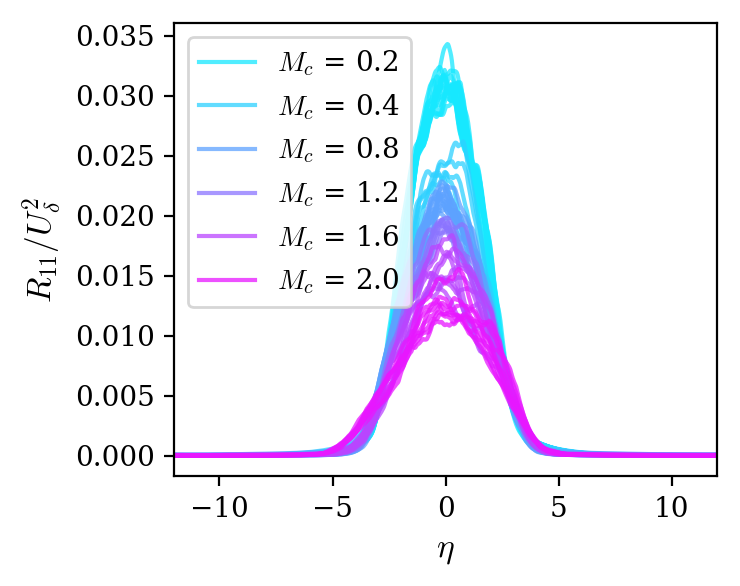

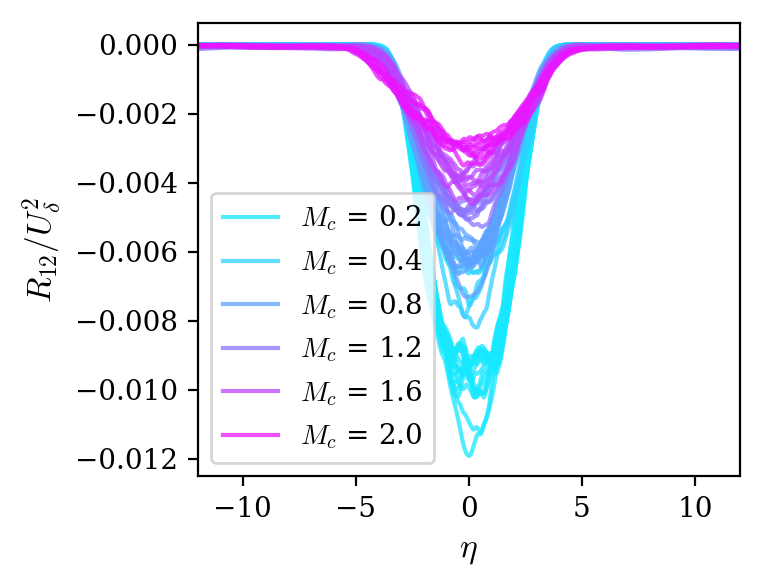

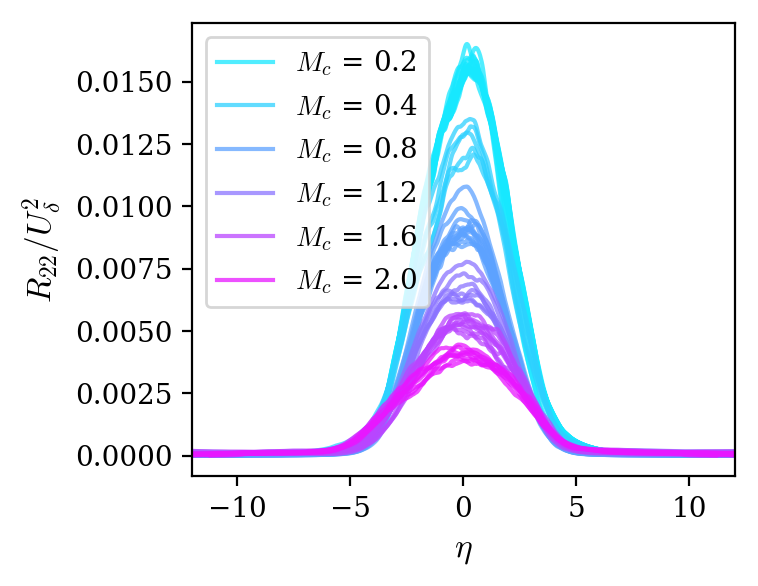

In [19]:
# Scaling using U_delta
s = '1'
# Mc_list = ['08',]#['02','08','20']
Mc_list = ['02','04','08','12','16','20']

jet = cm = plt.get_cmap('cool') 
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2.2)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)


for Rij_plot in ['R11','R12','R22']:
    print(Rij_plot + '= {')
    fig = plt.figure(figsize=(3.5,3),dpi=200)
    for i,Mc in enumerate(Mc_list):
        directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
        filename_prefix = directory + '/shearlayer_'
        inp = nml.inputs(directory)
        tlist,dlist,rates = growth_rates(directory+'shearlayer_')
        Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
        Ny = int(Ny)
        y = np.linspace(-Ly/2.,Ly/2.,Ny)
        
        flist = glob.glob(directory+"shearlayer_Rij*")
        flist.sort()

        if Mc=='02': ist=9;ien=-1
        elif Mc=='04': ist=4;ien=13-4
        elif Mc=='12': ist=4;ien=-1
        elif Mc=='20': ist=4;ien=-1
        else: ist=3; ien=None
        
        colorVal = scalarMap.to_rgba(inp.Mc)
        mat = np.zeros(len(flist[ist:ien]))
        for j,fname in enumerate(flist[ist:ien]):
            tID = fname.split('/')[-1]
            tID = tID.split('_')[-1]
            tID = int(tID.split('.')[0])
            time = nml.read_time(directory,tID)

            # Get dtheta
            idx = np.argmin(abs(tlist-time))
            dtheta = dlist[idx]
            eta = y/dtheta

            scale = 1./inp.du**2#(du[inp.Mc][0]*inp.du)**2
            d = get_Rij(fname)
            fplot = d[Rij_plot]*scale 
            #colorVal = 'C0'
            if j==0: plt.plot(-eta,fplot,alpha=0.75,color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
            else: plt.plot(-eta,fplot,alpha=0.75,color=colorVal)
            mat[j] = fplot[Ny/2]
        print('{}: [{},{}],'.format(inp.Mc,np.mean(mat[ist:ien]),np.std(mat[ist:ien])))
        
    if Rij_plot =='R11': Rij_title = r'$R_{11}$'
    if Rij_plot =='R12': Rij_title = r'$R_{12}$'
    if Rij_plot =='R22': Rij_title = r'$R_{22}$'
    plt.xlim([-12,12])
    plt.xlabel(r'$\eta$')
    plt.ylabel(Rij_title+r'$/U_\delta^2$')
    plt.legend(fontsize=10)
    
    print('}')


R12= {
}


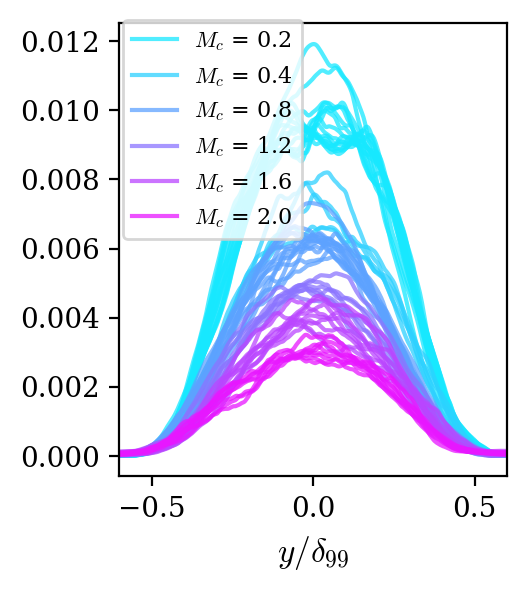

In [85]:
# Scaling with U_\delta and scale y with \delta_99
s = '1'
# Mc_list = ['08',]#['02','08','20']
Mc_list = ['02','04','08','12','16','20']

jet = cm = plt.get_cmap('cool') 
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2.2)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)


for Rij_plot in ['R12',]:
    print(Rij_plot + '= {')
    fig = plt.figure(figsize=(2.5,3),dpi=200)
    
    for i,Mc in enumerate(Mc_list):
        directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
        filename_prefix = directory + '/shearlayer_'
        inp = nml.inputs(directory)
        tlist,dlist,rates = growth_rates(directory+'shearlayer_')
        Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
        Ny = int(Ny)
        y = np.linspace(-Ly/2.,Ly/2.,Ny)
        
        flist = glob.glob(directory+"shearlayer_Rij*")
        flist.sort()

        if Mc=='02': ist=9;ien=-1
        elif Mc=='04': ist=4;ien=13-4
        elif Mc=='12': ist=4;ien=-1
        elif Mc=='20': ist=4;ien=-1
        else: ist=3; ien=None
        
        colorVal = scalarMap.to_rgba(inp.Mc)
        mat = np.zeros(len(flist[ist:ien]))
        for j,fname in enumerate(flist[ist:ien]):
            tID = fname.split('/')[-1]
            tID = tID.split('_')[-1]
            tID = int(tID.split('.')[0])
            time = nml.read_time(directory,tID)

            # Get dtheta
            idx = np.argmin(abs(tlist-time))
            dtheta = dlist[idx]
            eta = y/dtheta

            # Get L99
            utilde = np.fromfile(directory+'shearlayer_utilde_%04d.dat'%tID,sep=' ')
            L99,i1,i2 = get_L99(-y,utilde)
            eta=y/L99
            
            d = get_Rij(fname)
            scale = 1./inp.du**2#(du[inp.Mc][0]*inp.du)**2
            fplot = abs(d[Rij_plot])*scale
            
            #colorVal = 'C0'
            if j==0: plt.plot(-eta,fplot,alpha=0.75,color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
            else: plt.plot(-eta,fplot,alpha=0.75,color=colorVal)
            mat[j] = fplot[Ny/2]
        #print('{}: [{},{}],'.format(inp.Mc,np.mean(mat[ist:ien]),np.std(mat[ist:ien])))
        
    if Rij_plot =='R11': Rij_title = r'$R_{11}$'
    if Rij_plot =='R12': Rij_title = r'$|R_{12}|$'
    if Rij_plot =='R22': Rij_title = r'$R_{22}$'
    plt.xlim([-0.6,0.6])
    plt.xlabel(r'$y/\delta_{99}$')
    #plt.ylabel(Rij_title+r'$/U_\delta^2$')
    plt.legend(fontsize=8,bbox_to_anchor=(0.5,0.5))
    
    print('}')


R11= {
0.2: [0.00386311282316,0.000263838886479],
0.4: [0.00701686089662,0.00171543730264],
0.8: [0.0160913346143,0.00202906177604],
1.2: [0.0187231756529,0.00312781659132],
1.6: [0.0144779956024,0.00178533213106],
2.0: [0.014485261361,0.000127512287644],
}
R12= {
0.2: [-0.00121032176542,7.04249231638e-05],
0.4: [-0.00246906143179,0.000628400570877],
0.8: [-0.004629592226,0.000534032121042],
1.2: [-0.00442413074061,0.000622320323242],
1.6: [-0.00386312866645,0.000413132129349],
2.0: [-0.00353140224865,0.000193231509551],
}
R22= {
0.2: [0.00193839700422,0.000137521514356],
0.4: [0.00335502307982,0.000827270127225],
0.8: [0.00673557150576,0.000775160791133],
1.2: [0.00610476896873,0.000817070330596],
1.6: [0.00519828669258,0.000841495107216],
2.0: [0.00471581096836,0.000295715864074],
}


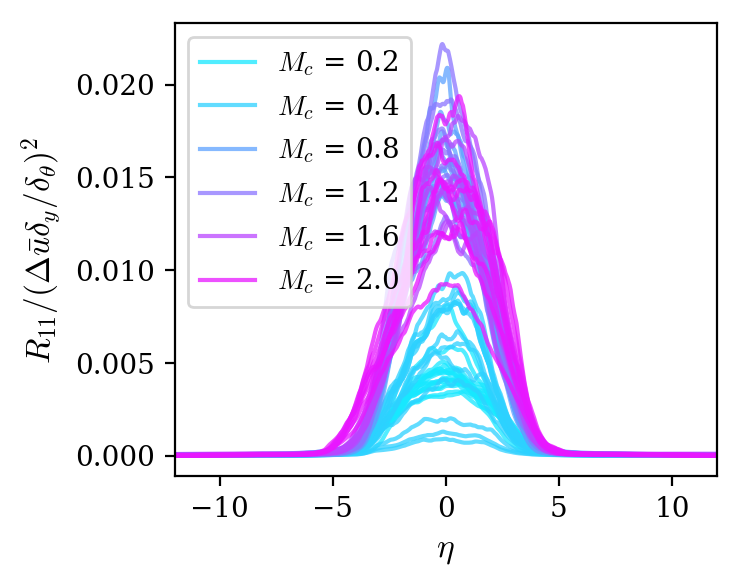

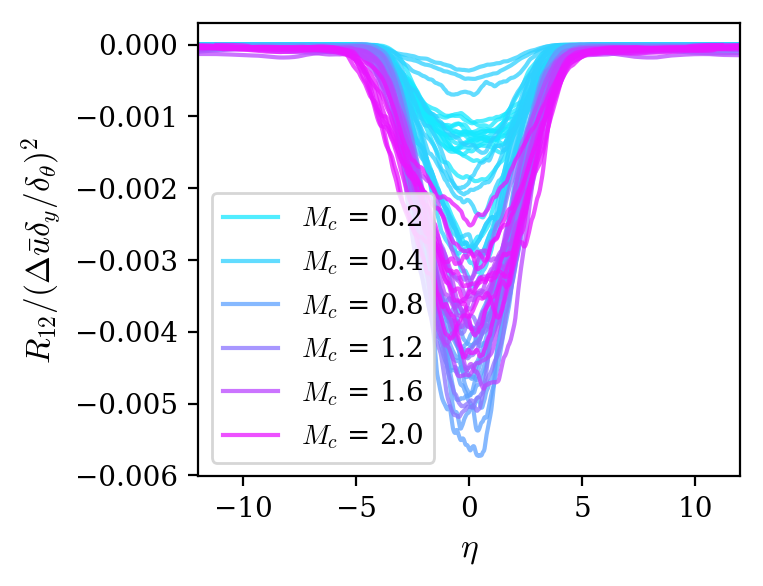

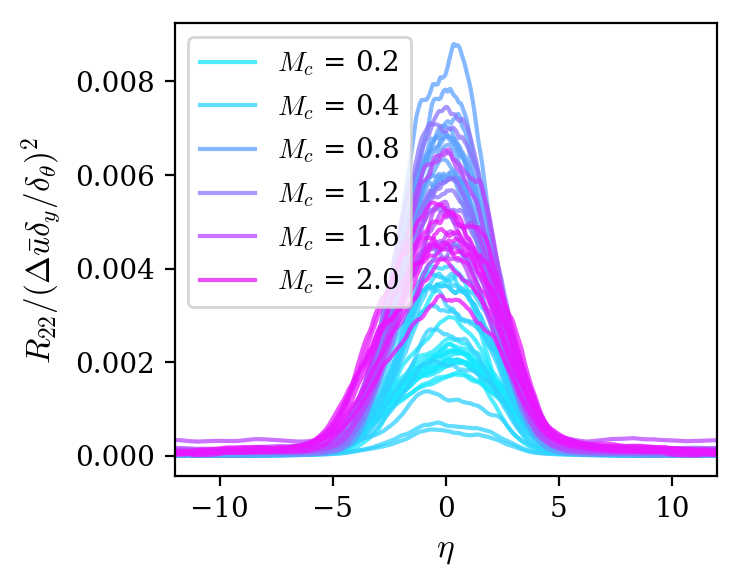

In [11]:
# Same as above but with Freund scaling (dU * delta_y/delta_theta)^2
s = '1'
Mc_list = ['02','04','08','12','16','20']

jet = cm = plt.get_cmap('cool') 
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2.2)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)


for Rij_plot in ['R11','R12','R22']:
    print(Rij_plot + '= {')
    fig = plt.figure(figsize=(3.5,3),dpi=200)
    for i,Mc in enumerate(Mc_list):
        directory = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
        filename_prefix = directory + '/shearlayer_'
        inp = nml.inputs(directory)
        tlist,dlist,rates = growth_rates(directory+'shearlayer_')
        Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
        Ny = int(Ny)
        y = np.linspace(-Ly/2.,Ly/2.,Ny)
        
        flist = glob.glob(directory+"shearlayer_Rij*")
        flist.sort()

        if Mc=='02': ist=9;ien=-1
        elif Mc=='04': ist=9;ien=None#13-4
        elif Mc=='12': ist=4;ien=-1
        elif Mc=='16': ist=2;ien=-2
        elif Mc=='20': ist=4;ien=-1
        else: ist=3; ien=None

        colorVal = scalarMap.to_rgba(inp.Mc)
        mat = np.zeros(len(flist[ist:ien]))
        for j,fname in enumerate(flist[ist:ien]):
            tID = fname.split('/')[-1]
            tID = tID.split('_')[-1]
            tID = int(tID.split('.')[0])
            time = nml.read_time(directory,tID)

            # Get dtheta
            idx = np.argmin(abs(tlist-time))
            dtheta = dlist[idx]
            eta = y/dtheta
            
            # Get y lscale
            autocorr = np.fromfile(directory+'lscale_vv_%04d.dat'%tID,sep=' ')
            autocorr = np.reshape(autocorr,[Ny,3])
            ly,i1,i2 = get_lscale(y,autocorr[:,0],thresh=0.2)
            
            scale = 1./(inp.du*ly/dtheta)**2#(du[inp.Mc][0]*inp.du)**2
            d = get_Rij(fname)
            fplot = d[Rij_plot]*scale 
            #colorVal = 'C%i'%j
            if j==0: plt.plot(-eta,fplot,alpha=0.75,color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
            else: plt.plot(-eta,fplot,alpha=0.75,color=colorVal)
            mat[j] = fplot[Ny/2]
        print('{}: [{},{}],'.format(inp.Mc,np.mean(mat[ist:ien]),np.std(mat[ist:ien])))
        
    if Rij_plot =='R11': Rij_title = r'$R_{11}$'
    if Rij_plot =='R12': Rij_title = r'$R_{12}$'
    if Rij_plot =='R22': Rij_title = r'$R_{22}$'
    plt.xlim([-12,12])
    plt.xlabel(r'$\eta$')
    plt.ylabel(Rij_title+r'$/(\Delta\bar{u}\delta_y/\delta_\theta)^2$')
    plt.legend(fontsize=10)
    print('}')


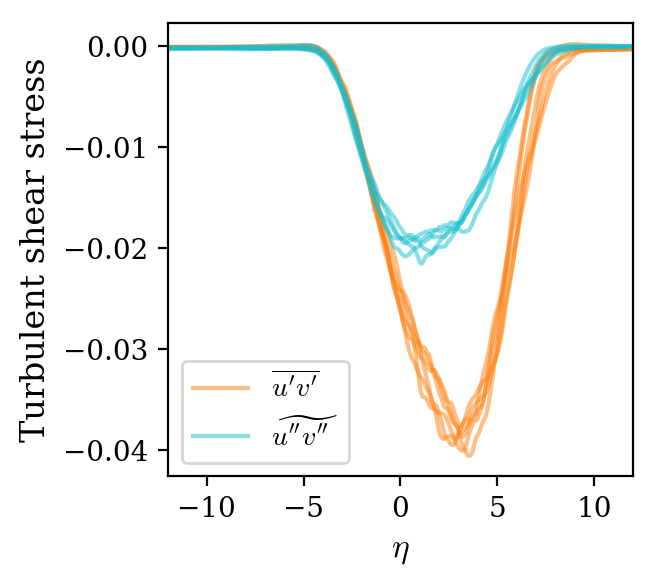

In [4]:
from matplotlib import cm

Rij_plot = 'R12'
directory = '/home/kmatsuno/ShearLayerData/production/Mc08/rr_7/1024x1448x512/'
inp = nml.inputs(directory)
tlist,dlist,rates = growth_rates(directory+'shearlayer_')
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

fig = plt.figure(figsize=(3,3),dpi=200)

labels = {'kinematic*':r"$\overline{u'v'}$",
          'shearlayer_Rij*':r"$\widetilde{u^{\prime\prime}v^{\prime\prime}}$"}
colors = {'kinematic*':'C1','shearlayer_Rij*':'C9'}


for i,prefix in enumerate(['kinematic*','shearlayer_Rij*']):
    flist = glob.glob(directory+prefix)
    flist.sort()
        
    colorVal = colors[prefix]
    for j,fname in enumerate(flist[4:]):
        tID = fname.split('/')[-1]
        tID = tID.split('_')[-1]
        tID = int(tID.split('.')[0])
        time = nml.read_time(directory,tID)

        # Get dtheta
        idx = np.argmin(abs(tlist-time))
        dtheta = dlist[idx]
        eta = y/dtheta

        # Get Rij
        d = get_Rij(fname)
        fplot = d[Rij_plot]
        if j==0: plt.plot(eta,fplot,alpha=0.5,color=colorVal,label=labels[prefix])
        else: plt.plot(eta,fplot,alpha=0.5,color=colorVal)
        
plt.xlim([-12,12])
plt.xlabel(r'$\eta$')
plt.ylabel('Turbulent shear stress')
plt.legend(fontsize=10)


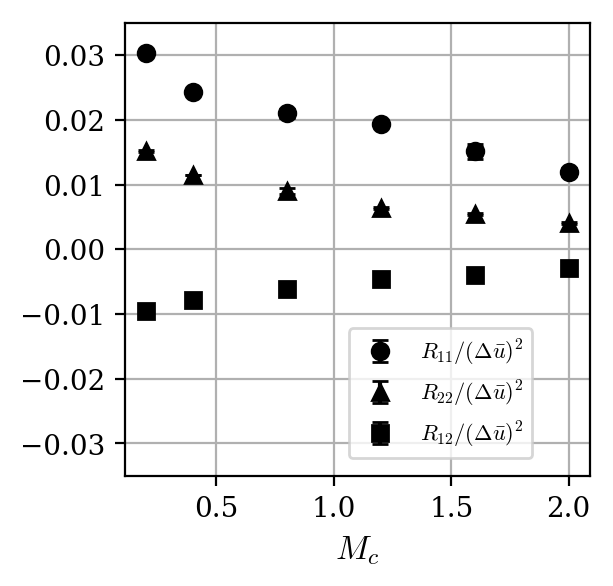

In [35]:

def plotter(dat,fmt,label):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()],
        yerr=[x[1] for x in dat.values()],fmt=fmt,capsize=3,label=label)

fig = plt.figure(figsize=(3,3),dpi=200)
plotter(Rij_orig['R11'],'ko',r'$R_{11}/(\Delta\bar{u})^2$')
plotter(Rij_orig['R22'],'k^',r'$R_{22}/(\Delta\bar{u})^2$')
plotter(Rij_orig['R12'],'ks',r'$R_{12}/(\Delta\bar{u})^2$');plt.ylim([-.035,0.035])
# plotter(R11,'ko',r'$R_{11}/U_\delta^2$')
# plotter(R22,'k^',r'$R_{22}/U_\delta^2$')
# plotter(R12,'ks',r'$R_{12}/U_\delta^2$')# plt.ylim([-0.9,0.9])
# plotter(R11,'ko',r'$R_{11}/(\Delta\bar{u}\delta_y/\delta_\theta)^2$')
# plotter(R22,'k^',r'$R_{22}/(\Delta\bar{u}\delta_y/\delta_\theta)^2$')
# plotter(R12,'ks',r'$R_{12}/(\Delta\bar{u}\delta_y/\delta_\theta)^2$')
# plt.ylim([-.9,0.9])

# plt.ylabel(r'$R_{ij}/\Delta \bar{u}^2$')
plt.xlabel('$M_c$')
plt.grid(True)
plt.legend(fontsize=8,bbox_to_anchor=(0.9,0.35))

Text(0.5,0,'$M_c$')

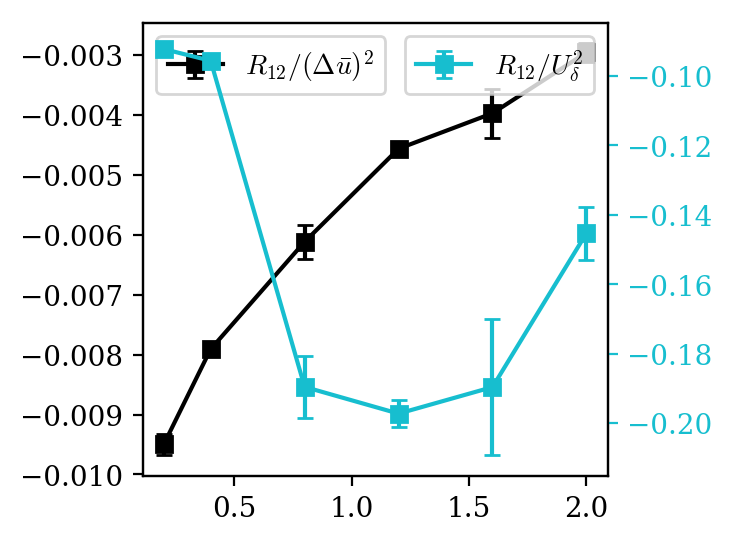

In [87]:
def plotter_v2(ax,dat,fmt,label,colorVal='k'):
    Mcs = []
    vals = []
    errs = []
    for Mc in sorted(dat.keys()):
        Mcs.append( Mc )
        vals.append( dat[Mc][0] )
        errs.append( dat[Mc][1] )
    plt.errorbar(Mcs,vals,color=colorVal,yerr=errs,fmt=fmt,capsize=3,label=label)

fig = plt.figure(figsize=(3,3),dpi=200)
ax = plt.gca()
# plotter_v2(ax,Rij_orig['R11'],'-o',r'$R_{11}/(\Delta\bar{u})^2$')
# plotter_v2(ax,Rij_orig['R22'],'-^',r'$R_{22}/(\Delta\bar{u})^2$')
plotter_v2(ax,Rij_orig['R12'],'-s',r'$R_{12}/(\Delta\bar{u})^2$')
plt.legend(fontsize=10)

ax2 = plt.twinx()
# plotter_v2(ax2,Rij_new['R11'],'-o',r'$R_{11}/U_\delta^2$',colorVal='C9')
# plotter_v2(ax2,Rij_new['R22'],'-^',r'$R_{22}/U_\delta^2$',colorVal='C9')
plotter_v2(ax2,Rij_new['R12'],'-s',r'$R_{12}/U_\delta^2$',colorVal='C9')
ax2.tick_params(axis='y', labelcolor='C9',color='C9')

plt.legend(fontsize=10)
plt.xlabel(r'$M_c$')

In [33]:
# New scaling by U_L^2
Rij_new = {}
Rij_new['R11'] = {
0.2: [0.293843711222,0.00325330230671],
0.4: [0.293470565035,0.0],
0.8: [0.650698808037,0.0223762119589],
1.2: [0.833648745932,0.003650242912],
1.6: [0.720909696822,0.0536631940398],
2.0: [0.587586297049,0.0309079057715],
}
Rij_new['R12'] = {
0.2: [-0.0922581775781,0.00170323829142],
0.4: [-0.0956370924709,0.0],
0.8: [-0.189619916753,0.00887031839743],
1.2: [-0.1973159584,0.00385801218789],
1.6: [-0.189665348106,0.0195658630548],
2.0: [-0.145340953059,0.00764697688911],
}
Rij_new['R22'] = {
0.2: [0.147289938023,0.00119826671228],
0.4: [0.13917560452,0.0],
0.8: [0.279279935631,0.0124920494724],
1.2: [0.27294468312,0.0069982342505],
1.6: [0.261218924191,0.00885381629255],
2.0: [0.200728528316,0.00937083892914],
}

In [34]:
#Original scaling by dU^2
Rij_orig = {}

Rij_orig['R11'] = {
0.2: [0.0302550577631,0.000334970072359],
0.4: [0.0242727692239,0.0],
0.8: [0.0210012438142,0.000722190170293],
1.2: [0.0193022572184,8.45175236464e-05],
1.6: [0.0151162303588,0.00112522443029],
2.0: [0.0119828394785,0.000630315028342],
}
Rij_orig['R12'] = {
0.2: [-0.00949918744265,0.000175370684902],
0.4: [-0.00791008486496,0.0],
0.8: [-0.00611996526589,0.000286288705423],
1.2: [-0.0045686428498,8.93282020346e-05],
1.6: [-0.00397695454185,0.000410262331619],
2.0: [-0.0029639855778,0.000155947300028],
}
Rij_orig['R22'] = {
0.2: [0.0151654277856,0.000123377248555],
0.4: [0.0115111283126,0.0],
0.8: [0.00901373407812,0.000403179740717],
1.2: [0.00631974618291,0.000162036730982],
1.6: [0.00547730936281,0.00018564922517],
2.0: [0.00409352251005,0.000191102582261],
}

In [24]:
#Freund scaling (dU*delta_y/delta_theta)^2
R11= {
0.2: [0.00387849889723,0.00026112113509],
0.4: [0.00700401004763,0.00171862250189],
0.8: [0.0160603606394,0.00207027849132],
1.2: [0.0187418453692,0.00309239782652],
1.6: [0.0144785762771,0.00176354636505],
2.0: [0.014475227274,0.000117776520424],
}
R12= {
0.2: [-0.00121682161279,7.04356070181e-05],
0.4: [-0.0024770331207,0.000633569281823],
0.8: [-0.00463247156412,0.000535641494845],
1.2: [-0.00441894763137,0.000625854645994],
1.6: [-0.0038671287489,0.000398725804012],
2.0: [-0.0035364587765,0.000208470658847],
}
R22= {
0.2: [0.00194463053654,0.000137131256143],
0.4: [0.00335203946115,0.00082775255201],
0.8: [0.00673885082995,0.000780881069254],
1.2: [0.00610667484175,0.000828409899824],
1.6: [0.0052083151842,0.000841376358462],
2.0: [0.00471859795127,0.000292664833353],
}